<a href="https://colab.research.google.com/github/Mahima-Bachhav/Fashion_MNIST/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
device

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [36]:
train_data =  datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

test_data =  datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

In [37]:
len(train_data), len(test_data)

(60000, 10000)

In [38]:
class_names = train_data.classes

In [39]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [40]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [41]:
print(f"Image shape: {image.shape}")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28])
Image label: Ankle boot


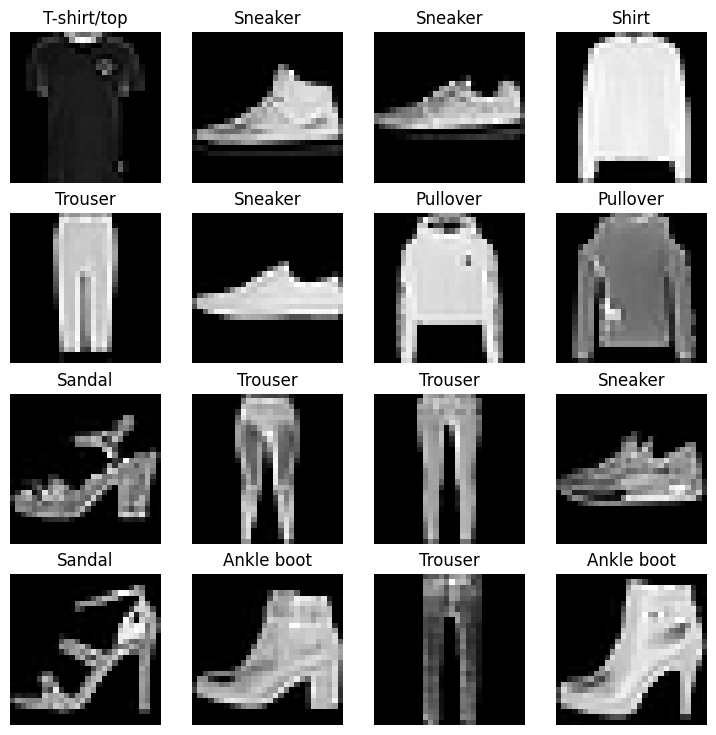

In [42]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols,i)
  plt.imshow(img.squeeze(), cmap = 'grey')
  plt.title(class_names[label])
  plt.axis('off')

plt.show()

In [43]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7fab042b9750>,
 <torch.utils.data.dataloader.DataLoader at 0x7fab042b9a80>)

In [44]:
print(f"dataloaders: {train_dataloader, test_dataloader}")
print(f"length of train_dataloader: {len(train_dataloader)}, in batches of: {batch_size}")
print(f"length of test_dataloader: {len(test_dataloader)}, in batches 0f: {batch_size}")

dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fab042b9750>, <torch.utils.data.dataloader.DataLoader object at 0x7fab042b9a80>)
length of train_dataloader: 1875, in batches of: 32
length of test_dataloader: 313, in batches 0f: 32


In [45]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [46]:
class GrayscaleToRGBTransform:
    def __call__(self, img):
        return img.repeat(3, 1, 1)

transform = transforms.Compose([
    transforms.ToTensor(),
    GrayscaleToRGBTransform(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data.transform = transform
test_data.transform = transform

In [47]:
from tqdm import tqdm
import copy
import time
import torch

def train_model(model, criterion, optimizer, scheduler, train_dataloader, test_dataloader, num_epochs=25, device='cpu'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataloaders = {'train': train_dataloader, 'val': test_dataloader}
    dataset_sizes = {'train': len(train_dataloader.dataset), 'val': len(test_dataloader.dataset)}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            phase_dataloader = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase', leave=False)
            for inputs, labels in phase_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization in the training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Update the best model if validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model


In [57]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

trained_model = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=10,
    device=device
)


Epoch 0/9
----------


train Loss: 0.4292 Acc: 0.8474


val Loss: 0.2911 Acc: 0.8954

Epoch 1/9
----------


train Loss: 0.2701 Acc: 0.9027


val Loss: 0.2561 Acc: 0.9053

Epoch 2/9
----------


train Loss: 0.2266 Acc: 0.9156


val Loss: 0.2457 Acc: 0.9129

Epoch 3/9
----------


train Loss: 0.2012 Acc: 0.9255


val Loss: 0.2531 Acc: 0.9071

Epoch 4/9
----------


train Loss: 0.1813 Acc: 0.9330


val Loss: 0.2489 Acc: 0.9114

Epoch 5/9
----------


train Loss: 0.1645 Acc: 0.9392


val Loss: 0.2322 Acc: 0.9214

Epoch 6/9
----------


train Loss: 0.1507 Acc: 0.9437


val Loss: 0.2317 Acc: 0.9204

Epoch 7/9
----------


train Loss: 0.1054 Acc: 0.9617


val Loss: 0.2178 Acc: 0.9262

Epoch 8/9
----------


train Loss: 0.0898 Acc: 0.9669


val Loss: 0.2210 Acc: 0.9256

Epoch 9/9
----------


train Loss: 0.0831 Acc: 0.9696


val Loss: 0.2282 Acc: 0.9270

Training complete in 7m 58s
Best val Acc: 0.927000


In [58]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [59]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
  test_samples.append(sample)
  test_labels.append(label)

In [60]:
pred_probs = make_predictions(model, test_samples)

In [61]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 4])

In [62]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 4]

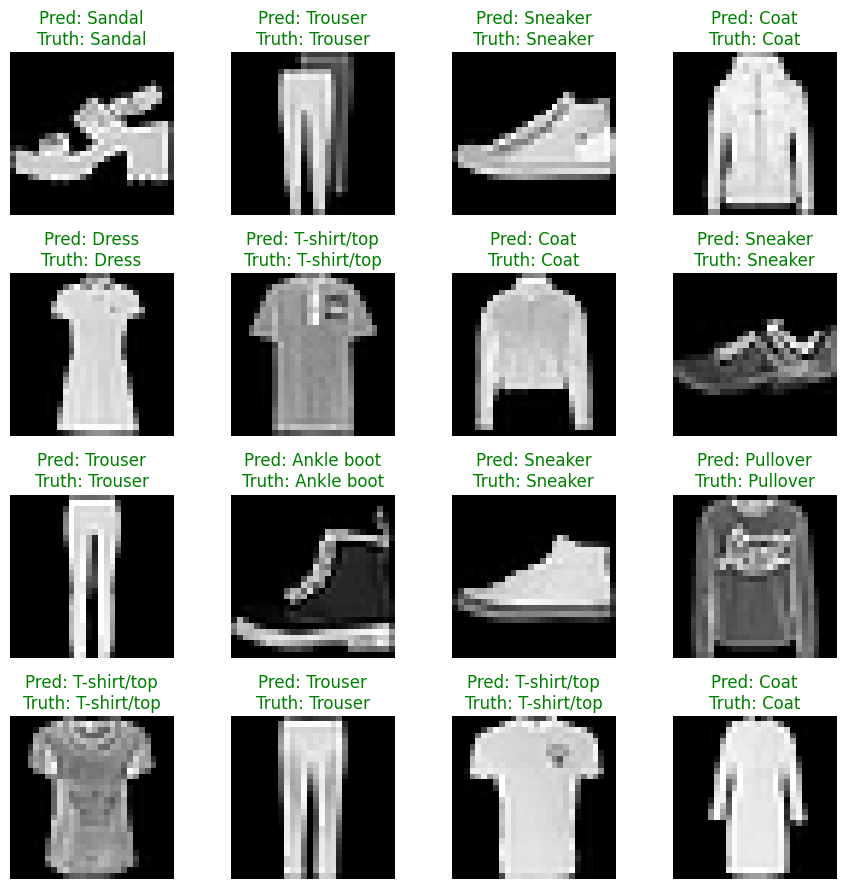

In [63]:
nrows, ncols = 4, 4
plt.figure(figsize=(9, 9))

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i + 1)
    grayscale_sample = sample.mean(dim=0)
    plt.imshow(grayscale_sample, cmap="gray")

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label}\nTruth: {truth_label}"

    title_color = "g" if pred_label == truth_label else "r"

    plt.title(title_text, fontsize=12, color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()
